It took me a while to come up with an (at least) semi-effective method of removing the text pattern. While the thicker outlines can be disposed of pretty easily ([click](https://magda.space/removing-circles-lines-patterns-part-1.html), [click](https://magda.space/removing-circles-lines-patterns-part-1-5.html)), developing a method which wouldn't harm the text too much turned out to be much more challenging.

Note that the text would be much easier to remove if it was (a) thicker (b) placed more regularly throughout the page, as a simple cv2.matchTemplate would most likely suffice (and the computation for e.g. a 12-page pdf would take around 50 seconds). Unfortunately, this wouldn't help with the task at hand, nor would a more sophisticated matching algorithm. (Unless you have a lot of data and feel adventurous.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

# a little helper function to display our image in a bigger plot
def display_img(image):
    fig = plt.figure(figsize=(20,16))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap="gray")

In [2]:
img = cv2.imread('obfuscated.jpg', 0)
img_med = cv2.medianBlur(img, ksize=15)
ret, th = cv2.threshold(img_med, 80, 255, cv2.THRESH_BINARY)
kernel = np.ones((3,3),np.uint8)
eroded_img = cv2.erode(th,kernel,iterations=2)
img_dest = img.copy()
img_dest[eroded_img == 0] = 255

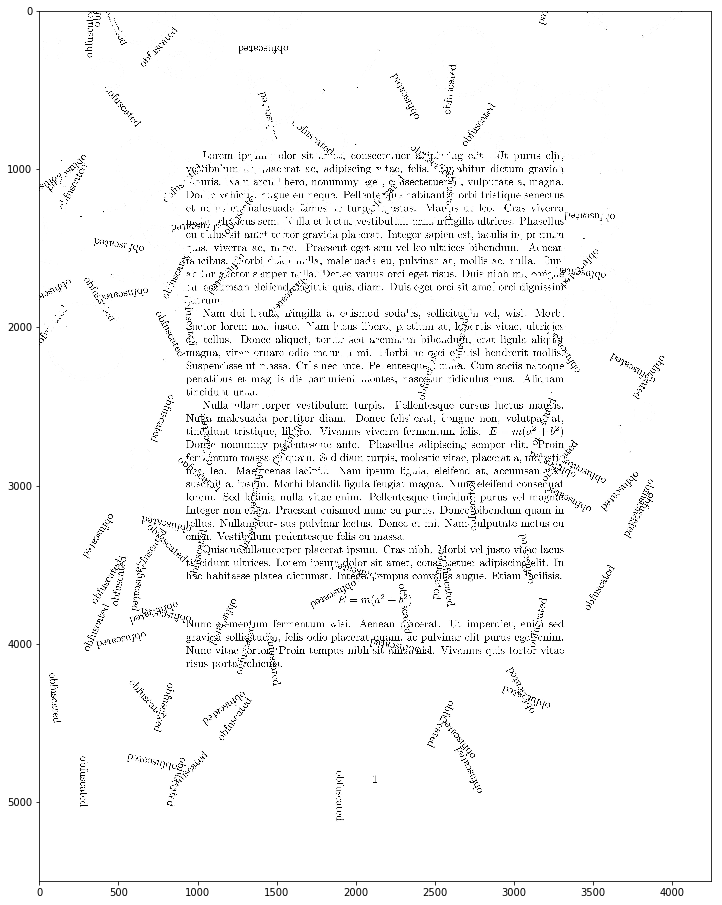

In [3]:
display_img(img_dest)

First, let's remove the obfuscation from the margins by simply changing the colour of all the margin pixels to white.

In [4]:
img_dest[:, :900] = 255
img_dest[:, 3350:] = 255
img_dest[:900, :] = 255
img_dest[4200:, :] = 255

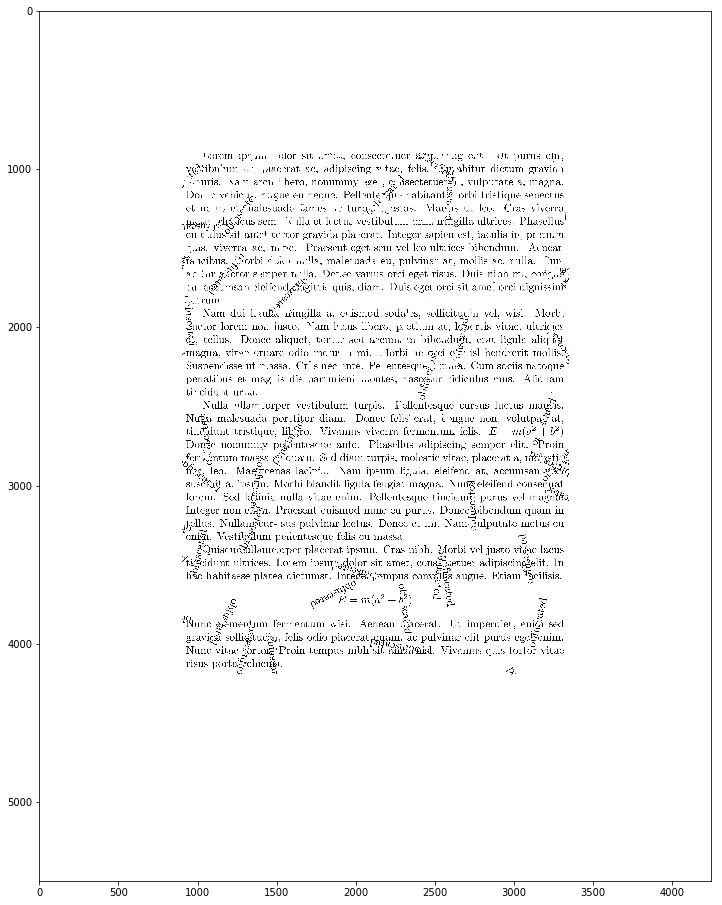

In [5]:
display_img(img_dest)

Next -- erode the image with a horizontal kernel to get some "FBI-redacted" style text.

In [6]:
kernel = np.ones((6,16),np.uint8)
eroded = cv2.erode(img_dest,kernel,iterations=6)
ret, th = cv2.threshold(eroded, 127, 255, cv2.THRESH_BINARY)

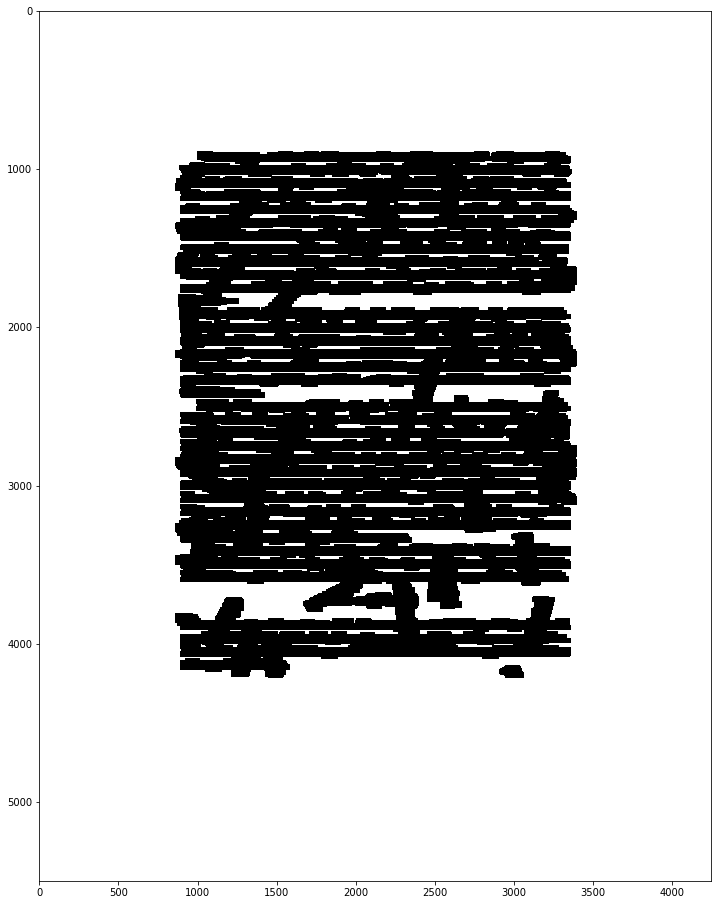

In [7]:
display_img(th)

As you can observe, the iritating vertical blobs are the remaining "obfuscated" tags. At this point I hoped I could get something out of this by measuring the gradient directions, but it would take way too much text away with it... so custom methods it is.

First, if in any row there is less black than my expected threshold, then the whole row can go to hell.

In [9]:
for index, row in enumerate(th):
    if cv2.countNonZero(row) > 0.6*len(row):
        th[index] = np.uint8(np.repeat(255,len(row)))

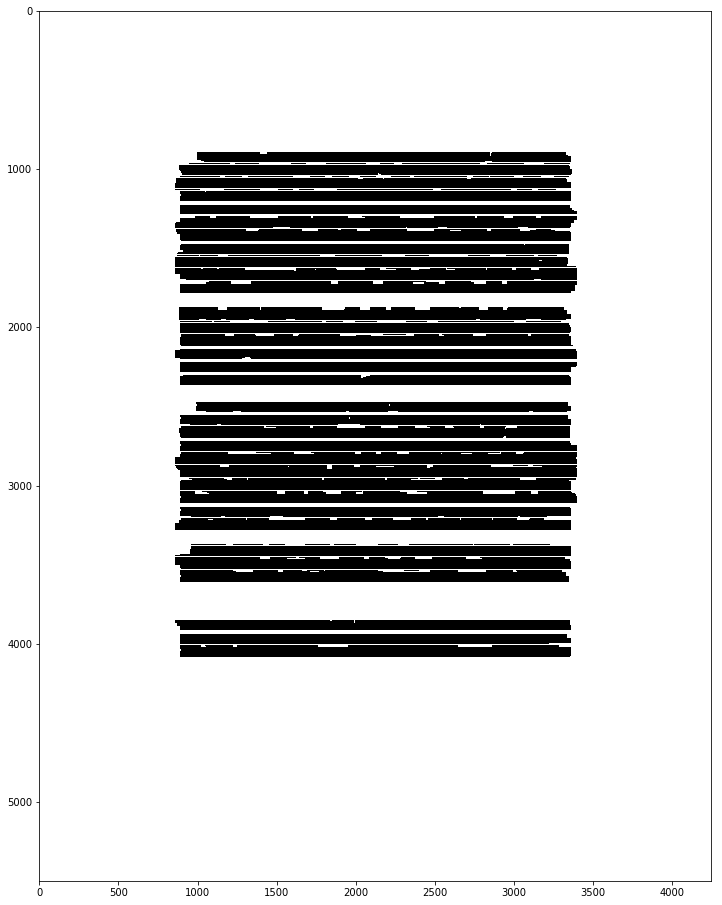

In [10]:
display_img(th)

Second, to only leave the longest sequence in the row let's first dilate it even more. (The kernel size depends on the line height -- if it's bigger and if there's more space between lines you can afford adding a bit more in the vertical axis. In this case it would turn the text into very thin lines.)

In [144]:
kernel = np.ones((2,8),np.uint8)
dilated = cv2.dilate(th,kernel,iterations=7)

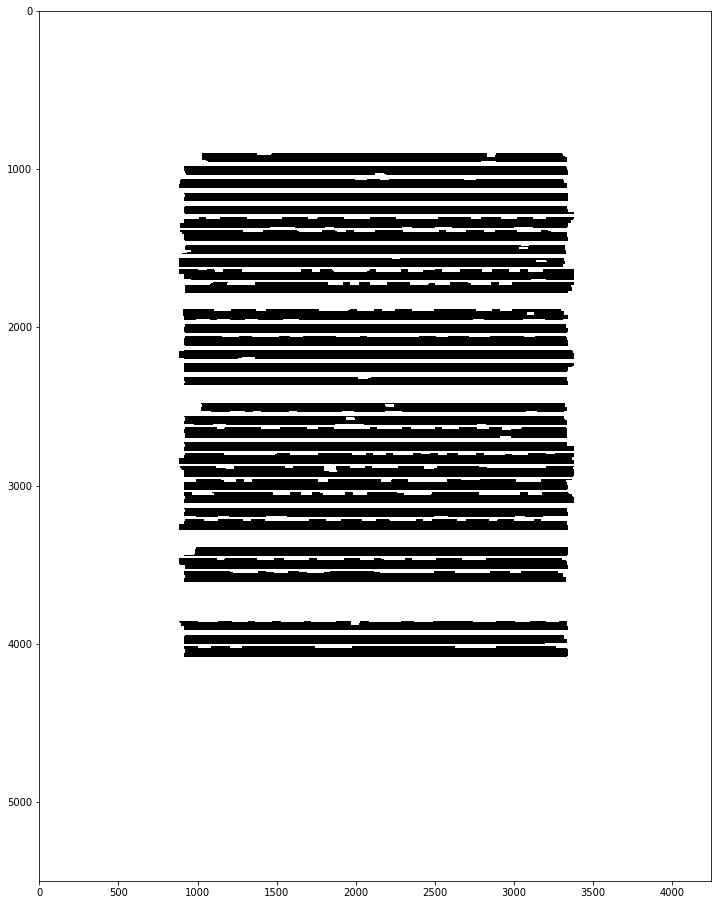

In [145]:
display_img(dilated)

In [149]:
img_dest[dilated == 255] = 255

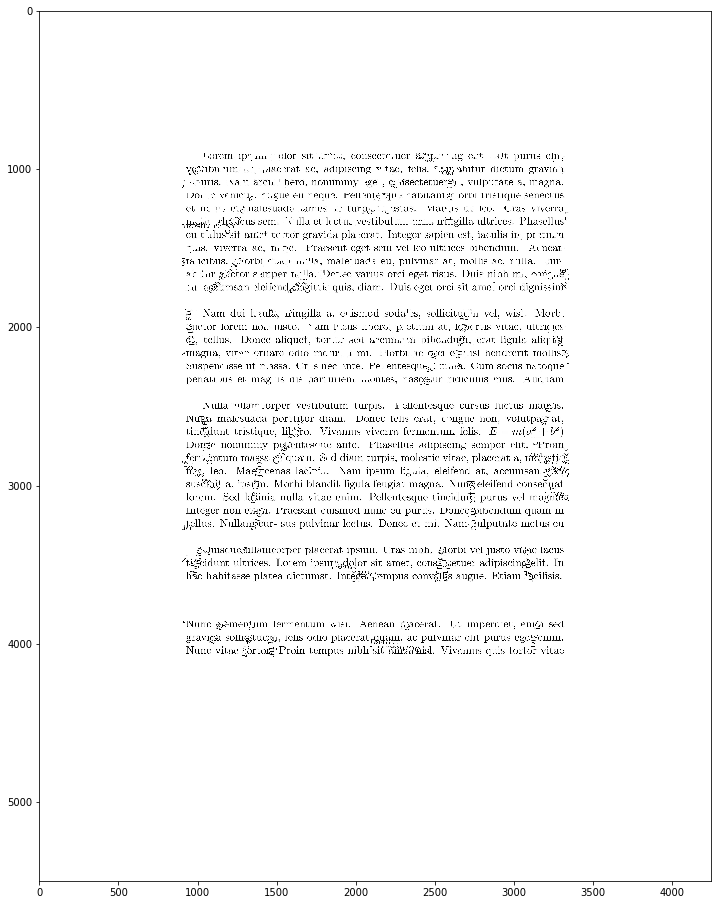

In [150]:
display_img(img_dest)

Again, depending on the exact document, you may have to use different parameters with the morphological operators, and the effect will be more (or less) prominent.